<a href="https://colab.research.google.com/github/arina19-2000/unimi/blob/main/tesi/kids_survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab


In [ ]:
pip install ydata-profiling

In [ ]:
pip install catboost

In [ ]:
pip install mord

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from patsy import dmatrices
from statsmodels.miscmodels.ordinal_model import OrderedModel
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from mord import LogisticIT, LAD
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from catboost import CatBoostClassifier
import shap

In [ ]:
df_kids = pd.read_excel('dfc.xlsx')

In [ ]:
df_kids

,Unnamed: 0,genere,adozione_int,adopt_age,prima_classe_frequenza_scuola,g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992,g2q00013_presenza_certificazione_sensi_l170_2010,g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni,g2q00036_fatto_esperienze_allestero,prospettive_economiche_rispetto_genitori_sonosaranno_encoded,...,esperienza_ss,esperienza_sp,g2q00022sq001_sq002_valutazione_voto100,g8q00002_qual_titolo_studio_massimo_conseguito_padre,g7q00002_qual_titolo_studio_massimo_conseguito_madre,g2q00015_qual_titolo_studio_massimo_conseguito,g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti,g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre,g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre,g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici
0,1,1,0,0,1,0,0,27,No,99,...,0,0,0,1.0,0.5,6,1,1,1,1
1,2,0,1,4,1,0,0,99,"Sì, di lavoro",99,...,0,1,70,7.0,7.0,3,3,1,1,1
2,6,0,1,1,1,0,1,99,No,99,...,1,0,85,3.0,6.0,3,1,4,4,1
3,9,0,1,11,99,1,0,26,No,99,...,0,0,0,3.0,6.0,6,2,4,3,4
4,14,1,0,9,6,0,0,24,"Sì, di studio (non estivo)",99,...,0,1,0,99.0,6.0,6,4,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,221,1,0,2,4,0,0,19,"Sì, di studio (non estivo)",99,...,0,2,0,3.0,5.0,3,3,4,2,1
101,224,1,0,1,3,0,0,26,"Sì, di lavoro",99,...,1,0,76,3.0,2.0,3,3,3,3,2
102,227,1,0,0,1,0,99,99,"Sì, di lavoro e di studio (non estivo)",99,...,1,2,0,5.0,6.0,4,99,99,2,1
103,233,0,0,0,3,99,99,24,No,99,...,0,0,0,2.0,3.0,3,3,3,2,2


In [ ]:
# Define the mapping for encoding
experience_mapping = {
    "Sì, di studio (non estivo)": 1,
    "Sì, di lavoro e di studio (non estivo)": 1,
    "Sì, di lavoro": 1,
    "No": 0,
    "99": 0
}

df_kids['g2q00036_fatto_esperienze_allestero'] = df_kids['g2q00036_fatto_esperienze_allestero'].map(experience_mapping)
print(df_kids['g2q00036_fatto_esperienze_allestero'].value_counts())

g2q00036_fatto_esperienze_allestero
0.0    68
1.0    30
Name: count, dtype: int64


In [ ]:
df_kids = df_kids.apply(lambda col: col.replace(99, col.mode()[0]) if 99 in col.values else col)


In [ ]:
df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'] = df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'].replace({7: 6, 8: 6,1:2, 4:5})

In [ ]:
df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'].value_counts()

,count
g2q00015_qual_titolo_studio_massimo_conseguito,
3,43
5,27
2,19
6,16


In [ ]:
df_kids = df_kids.dropna(subset=['g2q00015_qual_titolo_studio_massimo_conseguito'])

In [ ]:
df_kids = df_kids.drop(columns=['Unnamed: 0','prospettive_economiche_rispetto_genitori_sonosaranno_encoded','esperienza_uni'])

In [ ]:
for col in df_kids.columns:
    print(col)

genere
adozione_int
adopt_age
prima_classe_frequenza_scuola
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
g2q00013_presenza_certificazione_sensi_l170_2010
g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni
g2q00036_fatto_esperienze_allestero
esperienza_ss
esperienza_sp
g2q00022sq001_sq002_valutazione_voto100
g8q00002_qual_titolo_studio_massimo_conseguito_padre
g7q00002_qual_titolo_studio_massimo_conseguito_madre
g2q00015_qual_titolo_studio_massimo_conseguito
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre
g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre
g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici


In [ ]:
target_variable = "g2q00015_qual_titolo_studio_massimo_conseguito"
numeric_vars = ["adopt_age", "g2q00022sq001_sq002_valutazione_voto100", "g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni"]

categorical_vars = [col for col in df_kids.columns if col not in numeric_vars + [target_variable]]
df_cleaned = df_kids.dropna(axis=1, thresh=len(df_kids) * 0.7).copy()

for col in numeric_vars:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

if numeric_vars:
    scaler = StandardScaler()
    df_cleaned[numeric_vars] = scaler.fit_transform(df_cleaned[numeric_vars])

for col in categorical_vars:
    if col in df_cleaned.columns:
        if df_cleaned[col].dropna().shape[0] > 0:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].dropna().mode()[0])

print("Missing values:\n", df_cleaned.isnull().sum().sum())

Missing values:
 0


In [ ]:
target_column = "g2q00015_qual_titolo_studio_massimo_conseguito"

numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_column]

z_scores = df_cleaned[numeric_cols].apply(zscore, nan_policy='omit')
outlier_rows = df_cleaned[(z_scores > 3).any(axis=1) | (z_scores < -3).any(axis=1)]
filtered_outlier_rows = outlier_rows[outlier_rows[target_column] != 3].copy()

for col in numeric_cols:
    upper_bound = df_cleaned[col].mean() + 3 * df_cleaned[col].std()
    lower_bound = df_cleaned[col].mean() - 3 * df_cleaned[col].std()

    filtered_outlier_rows.loc[:, col] = filtered_outlier_rows[col].clip(lower=lower_bound, upper=upper_bound).astype(df_cleaned[col].dtype)

df_cleaned.update(filtered_outlier_rows)


In [ ]:
# outliers = (z_scores > 3) | (z_scores < -3)
# outlier_counts = outliers.sum()

# # Summarize outliers
# outlier_summary = pd.DataFrame({
#     "Column": numeric_cols,
#     "Outlier Count": outlier_counts
# }).sort_values(by="Outlier Count", ascending=False)
# print(outlier_summary)

In [ ]:
profile = ProfileReport(df_kids, title="Profiling Report")

In [ ]:
def gauss_markov_assumptions(X, y):

    # 1. Independence of Errors: Durbin-Watson test
    X_with_intercept = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_intercept).fit()
    dw_statistic = sm.stats.durbin_watson(ols_model.resid)
    print(f"Durbin-Watson statistic: {dw_statistic}")


    # 2. Breusch-Pagan Test for homoscedasticity
    bp_test = sms.het_breuschpagan(ols_model.resid, ols_model.model.exog)
    print(f"Breusch-Pagan Test p-value: {bp_test[1]}")

    # 3. VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

X = df_cleaned.drop(columns=['g2q00015_qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['g2q00015_qual_titolo_studio_massimo_conseguito']

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Class distribution in y_train:")
print(y_train.value_counts())

print("\nClass distribution in y_test:")
print(y_test.value_counts())

Class distribution in y_train:
g2q00015_qual_titolo_studio_massimo_conseguito
3    35
5    21
2    15
6    13
Name: count, dtype: int64

Class distribution in y_test:
g2q00015_qual_titolo_studio_massimo_conseguito
3    8
5    6
2    4
6    3
Name: count, dtype: int64


In [ ]:
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 2.22442933459397
Breusch-Pagan Test p-value: 0.037685624459196744

Variance Inflation Factors (VIF):
                                              feature        VIF
0                                              genere   3.451937
1                                        adozione_int   2.454259
2                                           adopt_age   1.594992
3                       prima_classe_frequenza_scuola   7.328209
4   g2q00012_presenza_patologie_certificate_sensi_...   1.646220
5    g2q00013_presenza_certificazione_sensi_l170_2010   1.459424
6   g2q00035sq001_sq001_età_conquistato_indipenden...   1.431620
7                 g2q00036_fatto_esperienze_allestero   2.148693
8                                       esperienza_ss   2.277185
9                                       esperienza_sp   2.480061
10            g2q00022sq001_sq002_valutazione_voto100   2.102385
11  g8q00002_qual_titolo_studio_massimo_conseguito...   8.545870
12  g7q00002_qual_titolo_stud

In [ ]:
# high_vif_columns = ['g8q00002_qual_titolo_studio_massimo_conseguito_padre','prospettive_economiche_rispetto_genitori_sonosaranno_encoded']

# df_cleaned = df_cleaned.drop(columns=high_vif_columns)

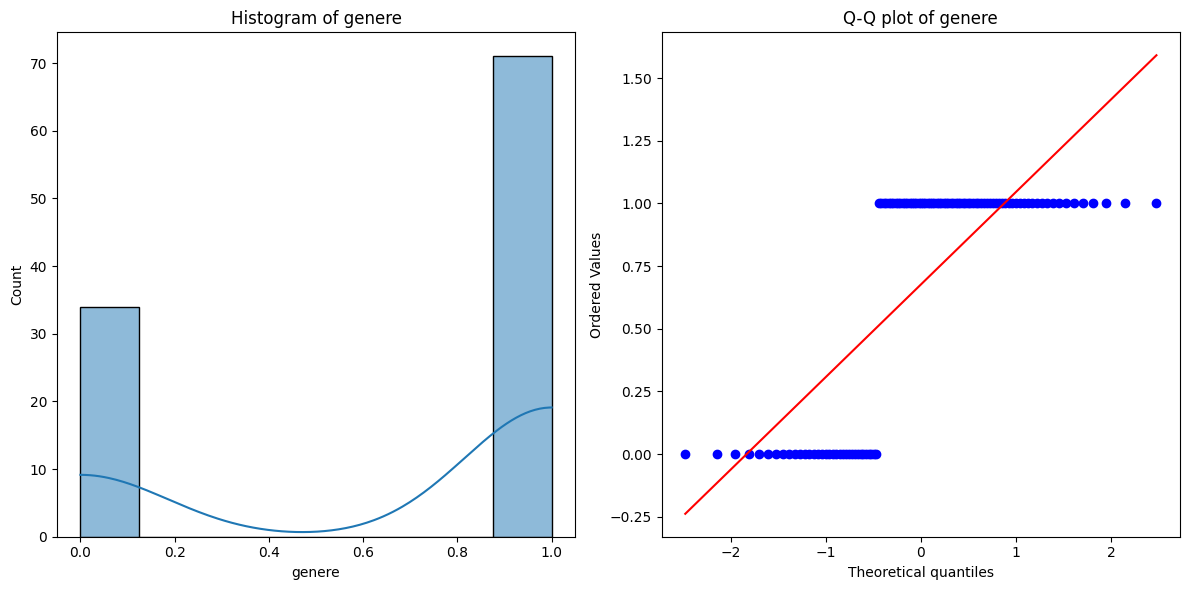

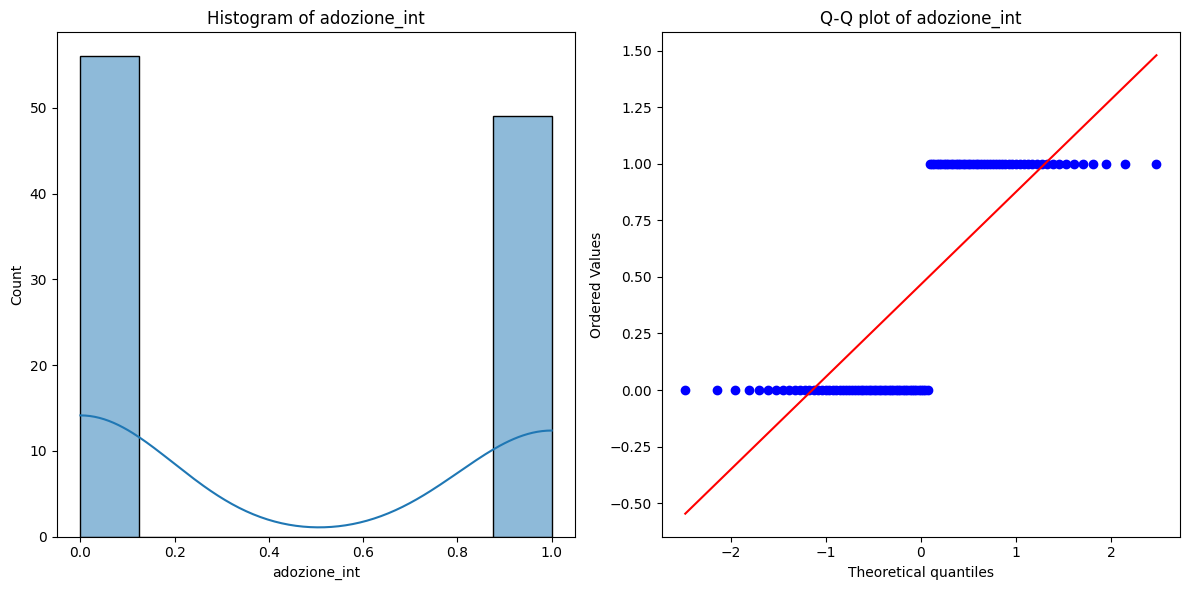

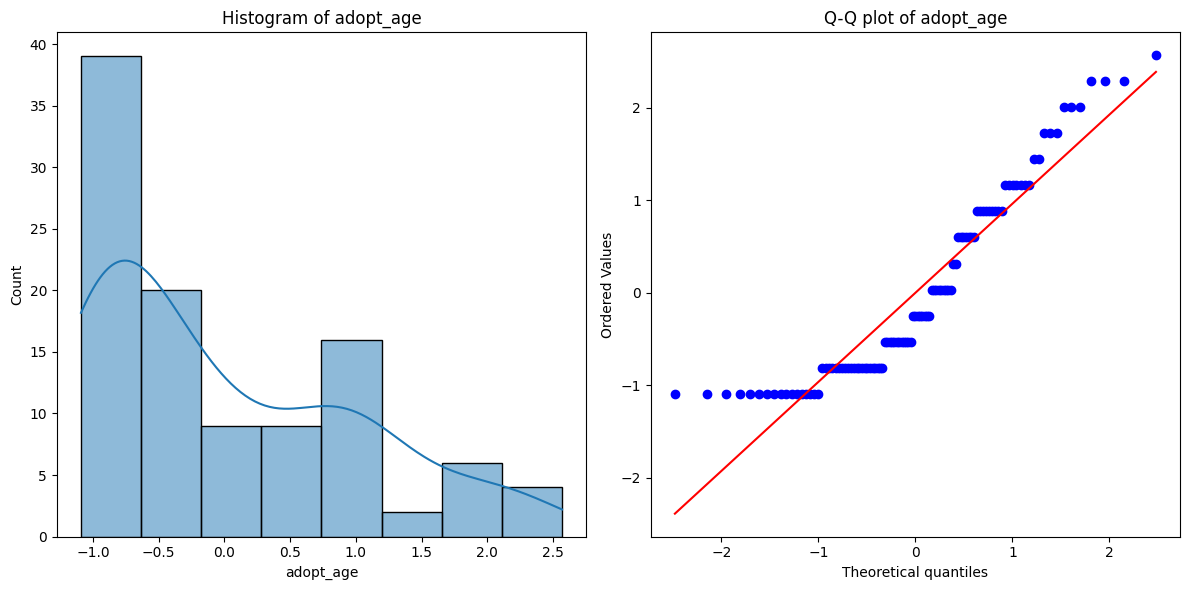

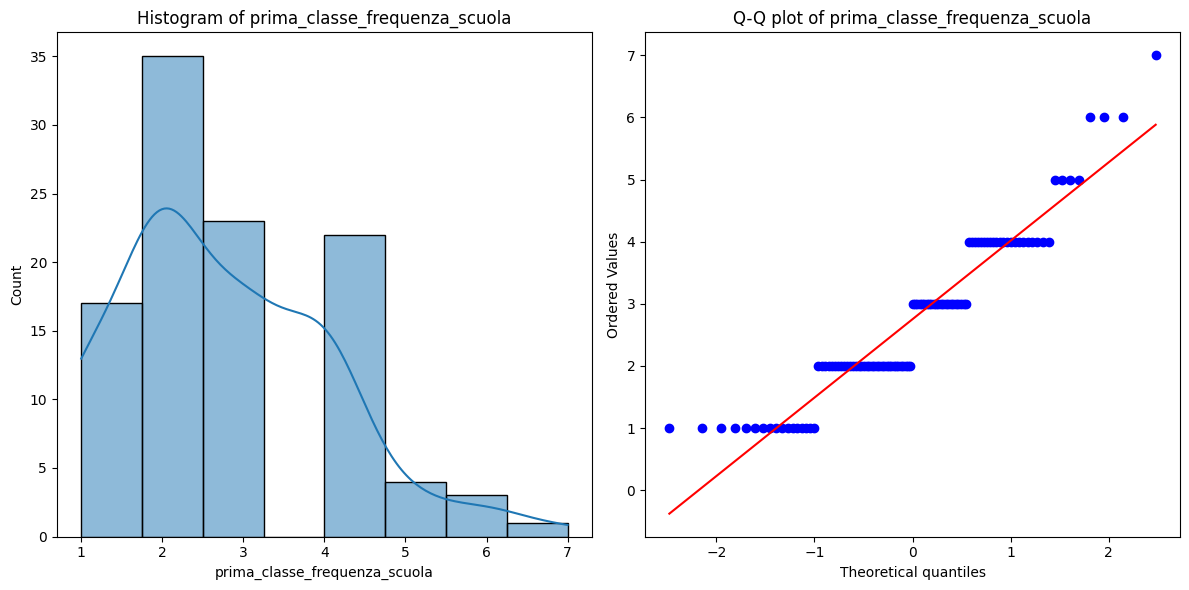

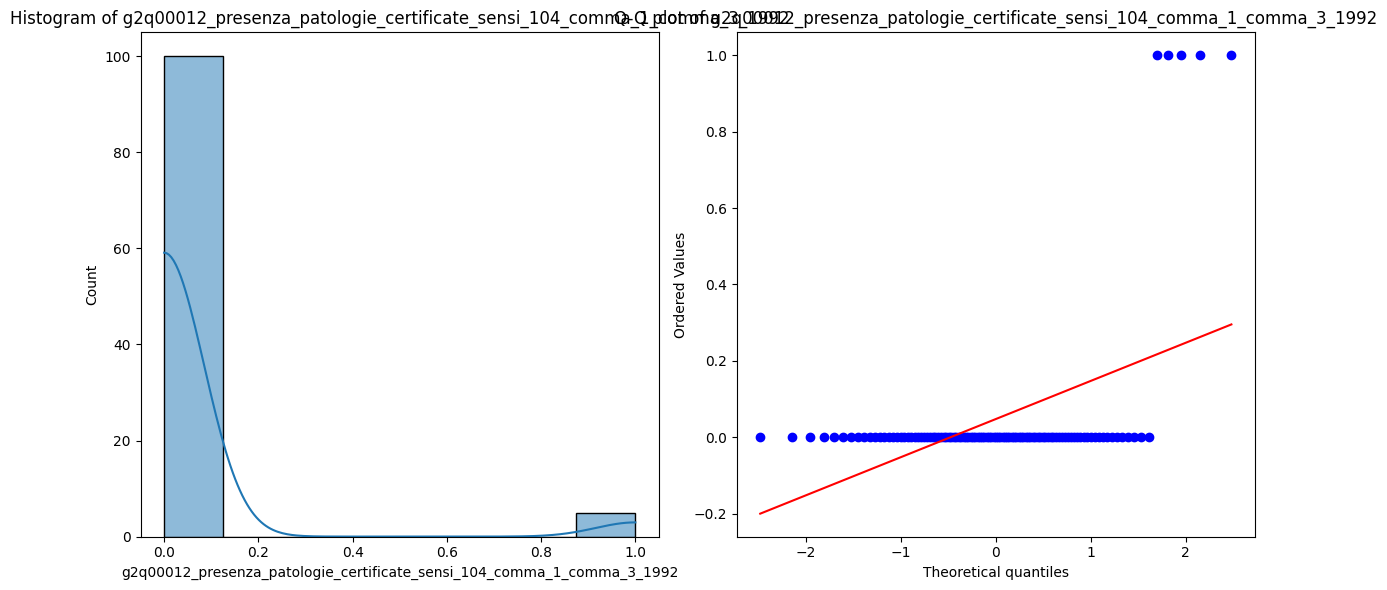

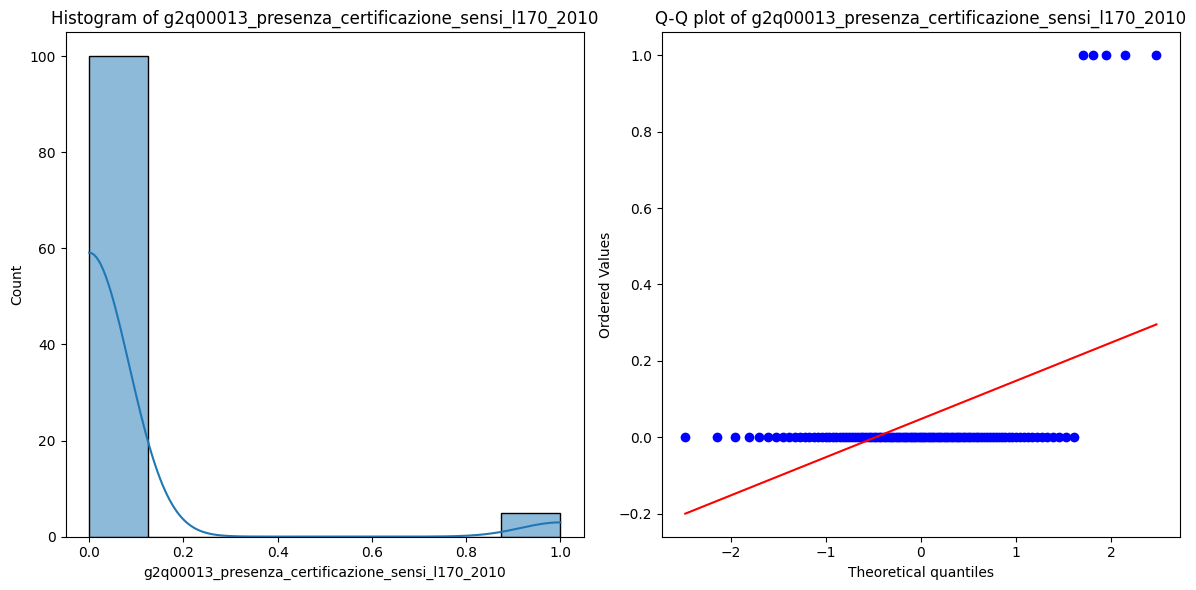

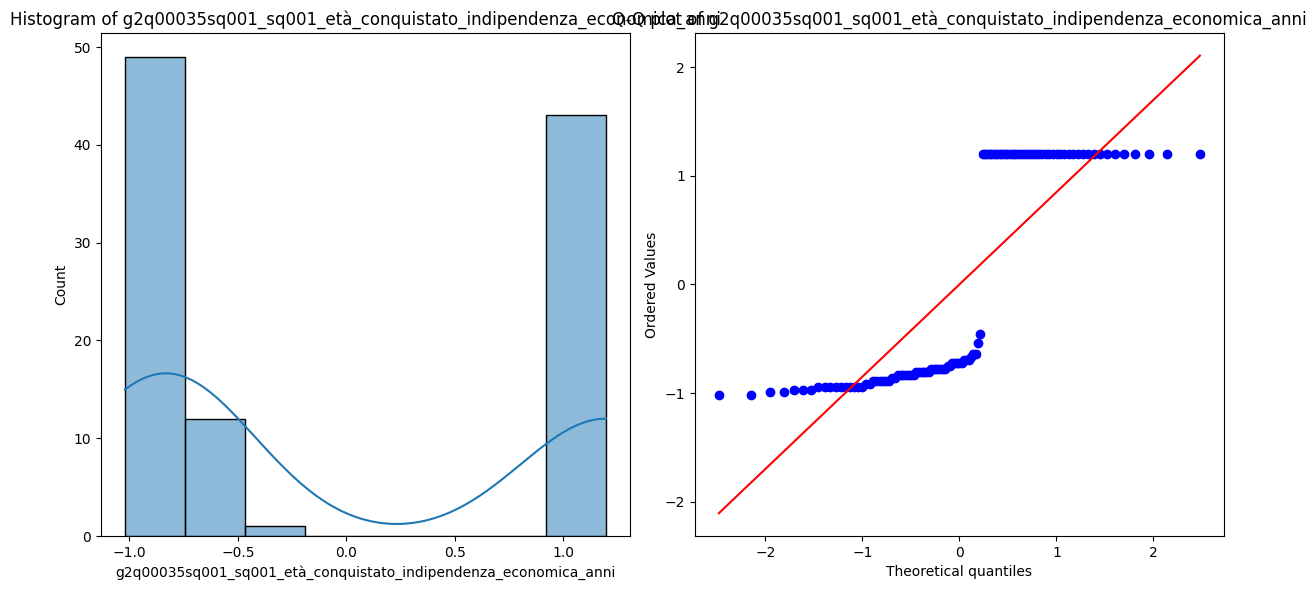

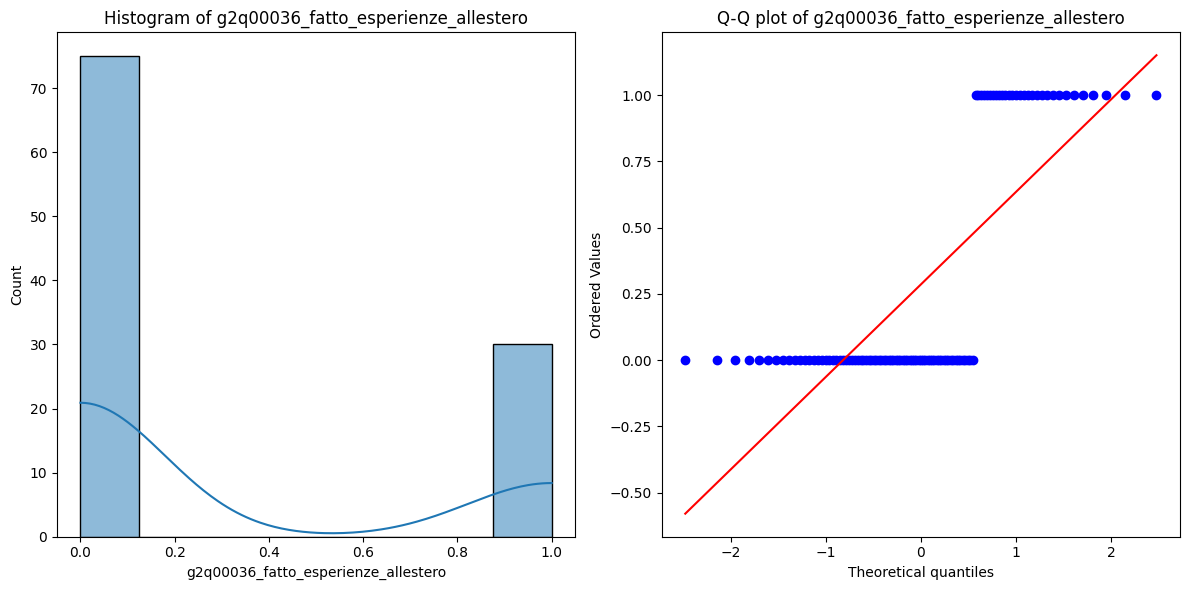

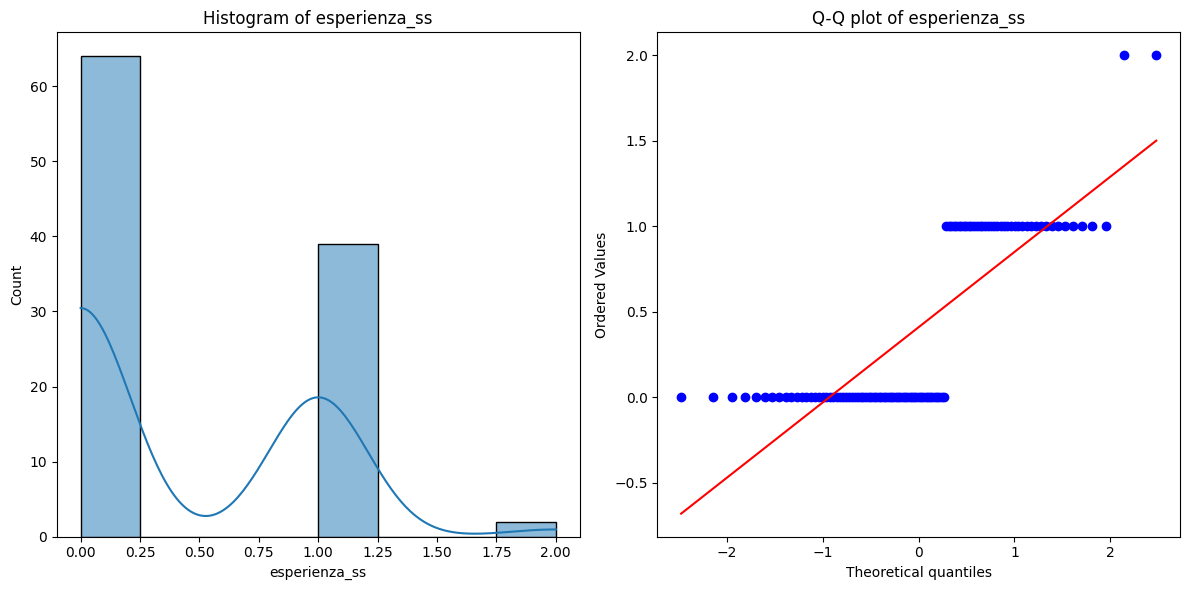

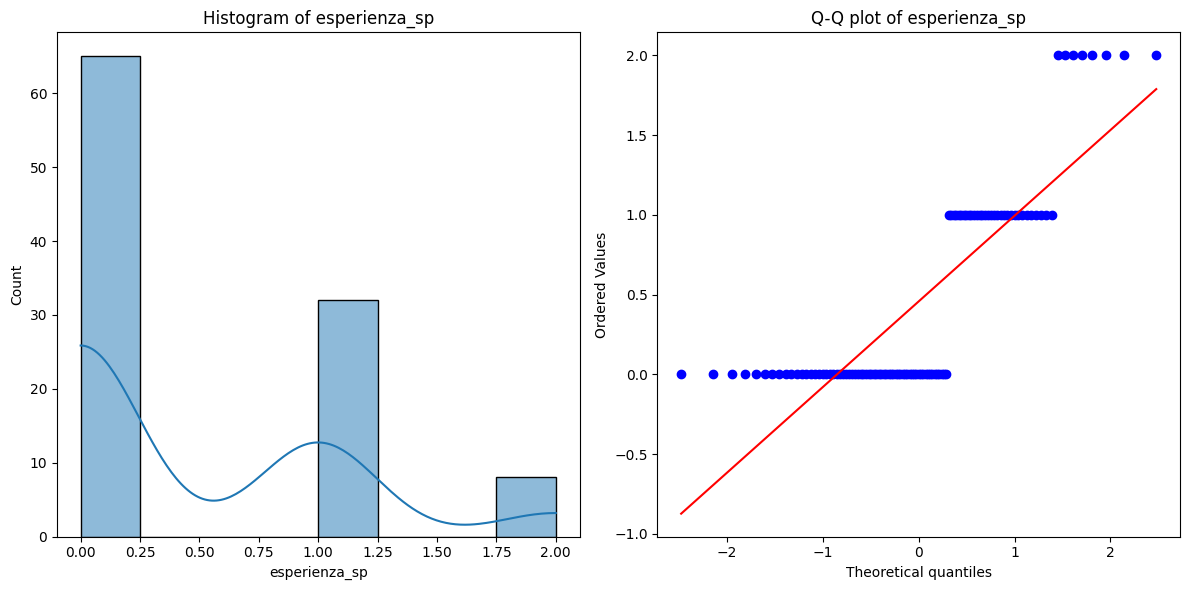

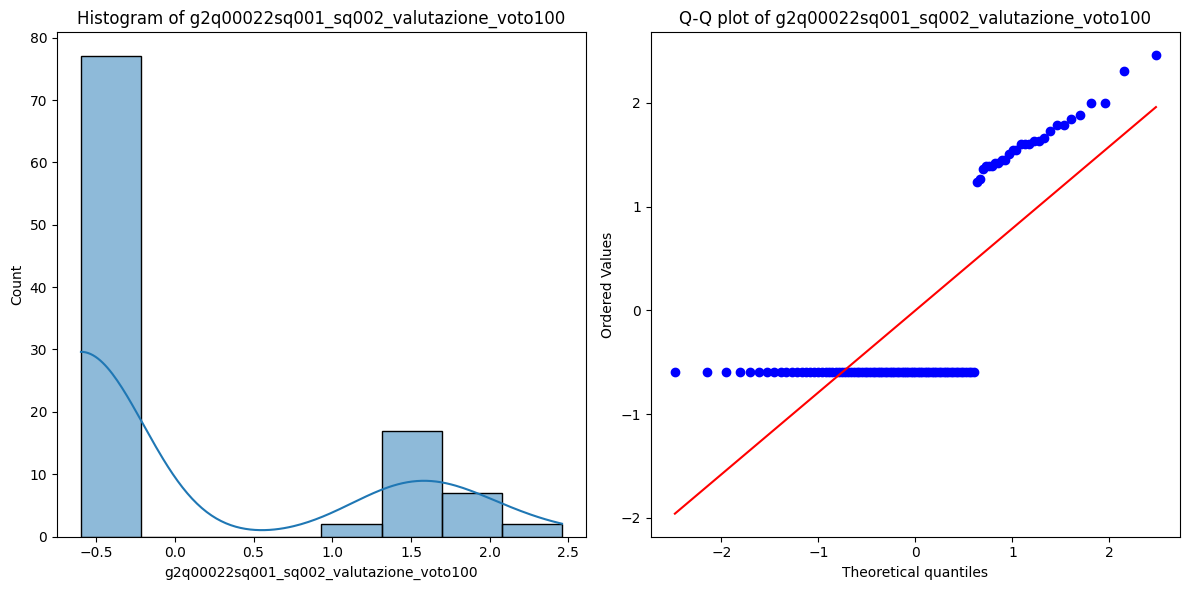

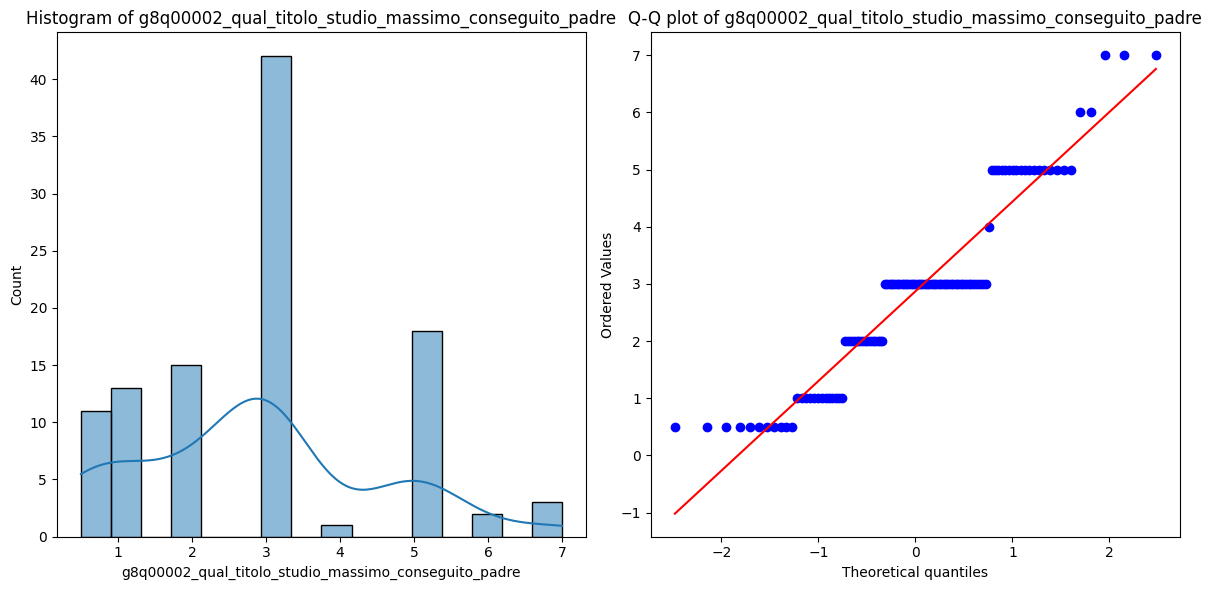

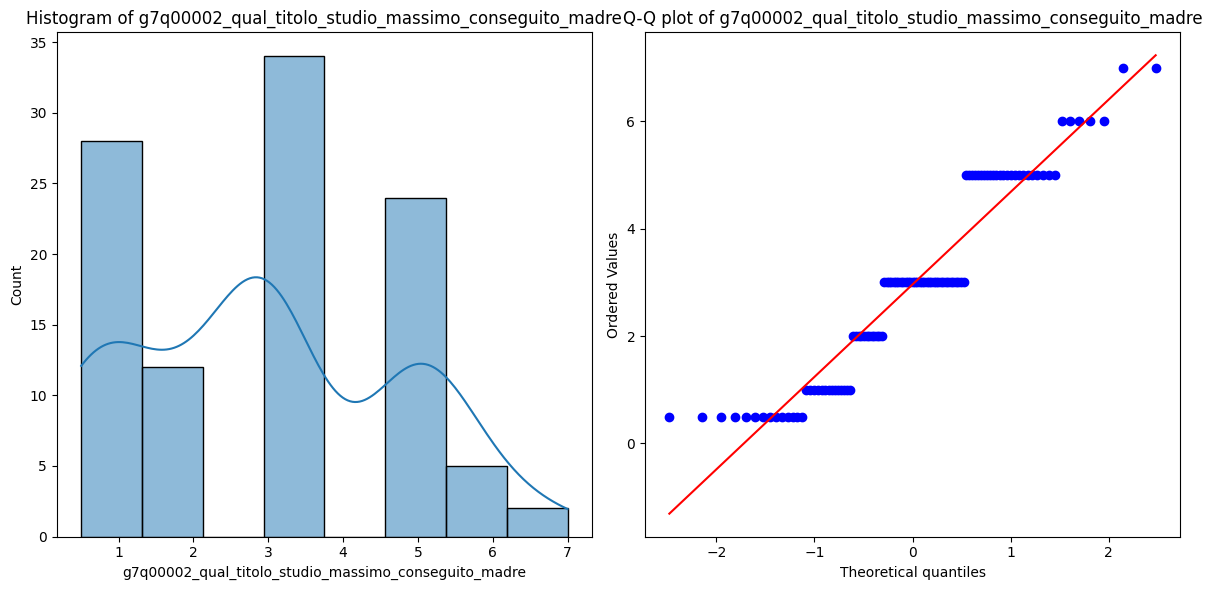

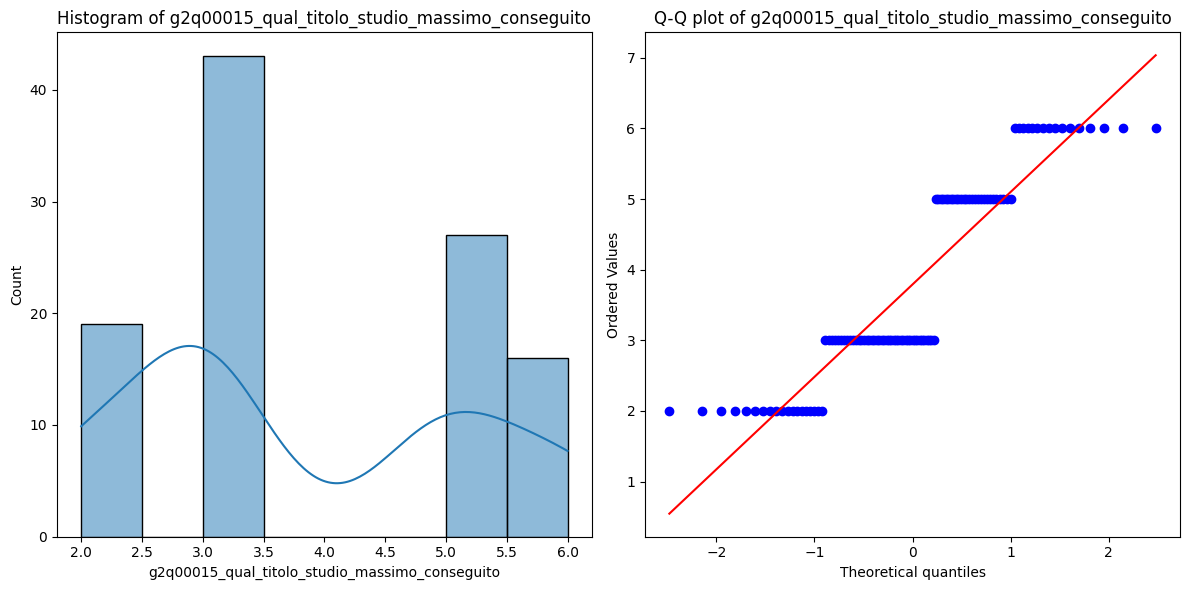

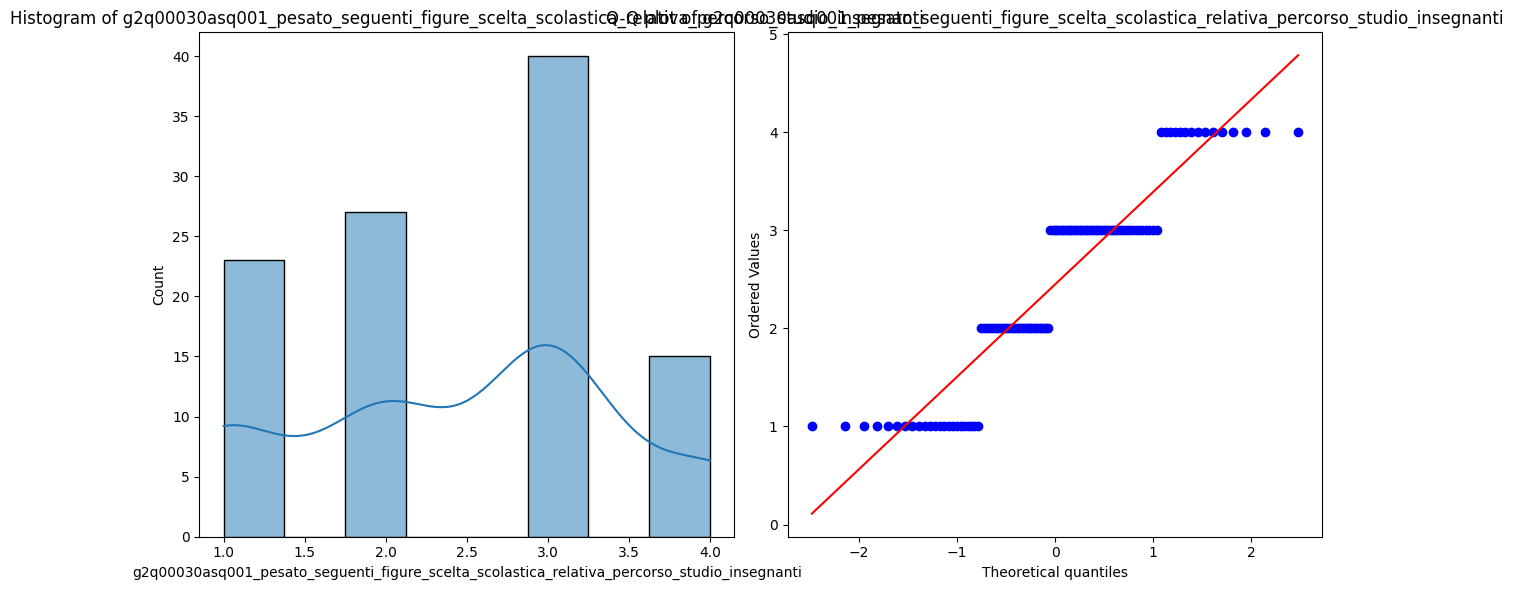

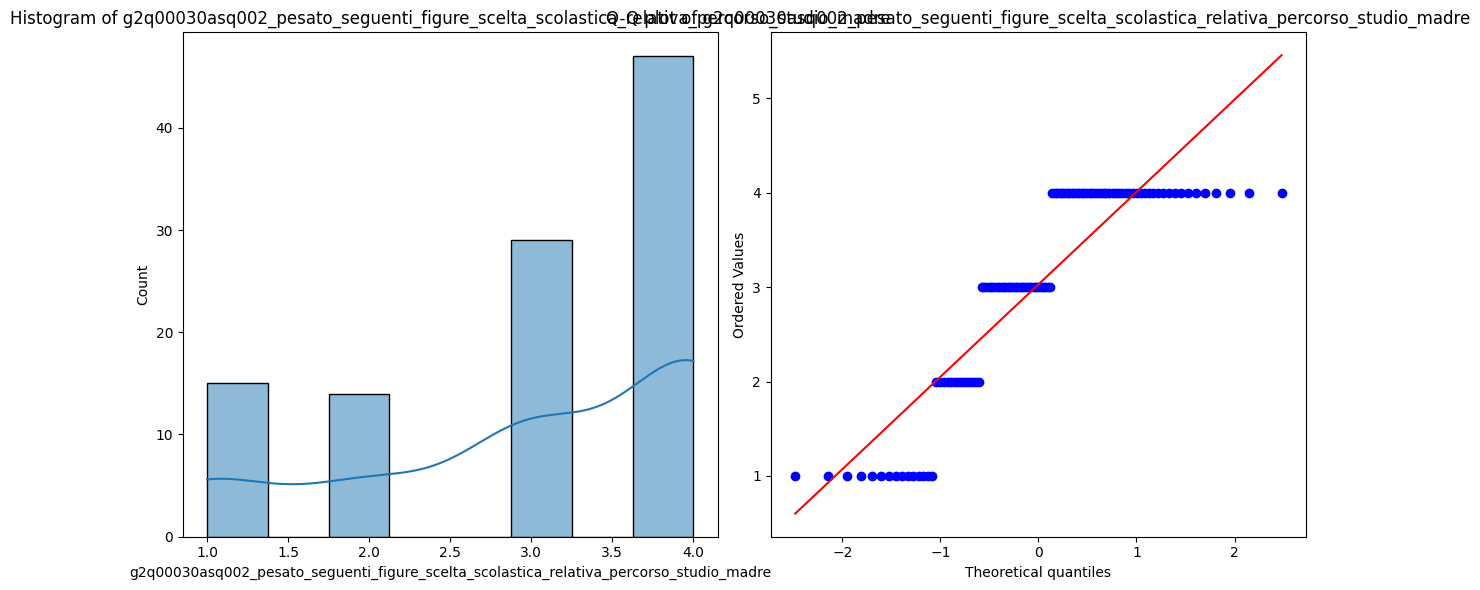

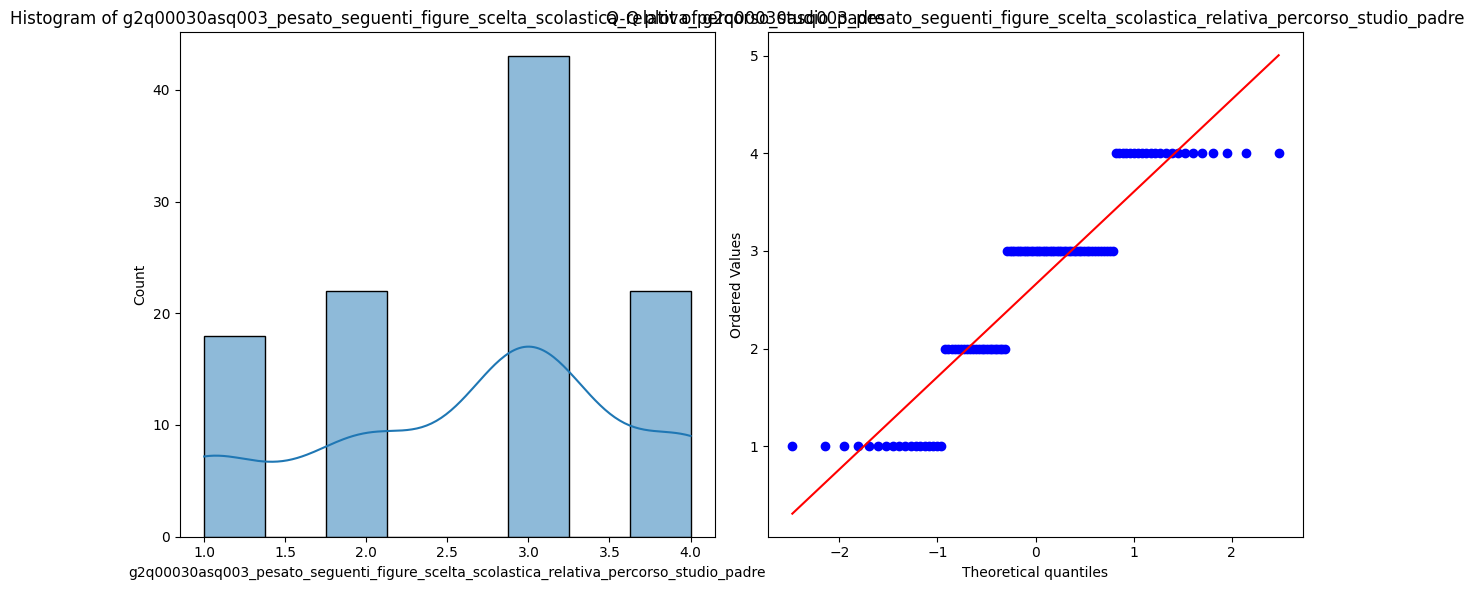

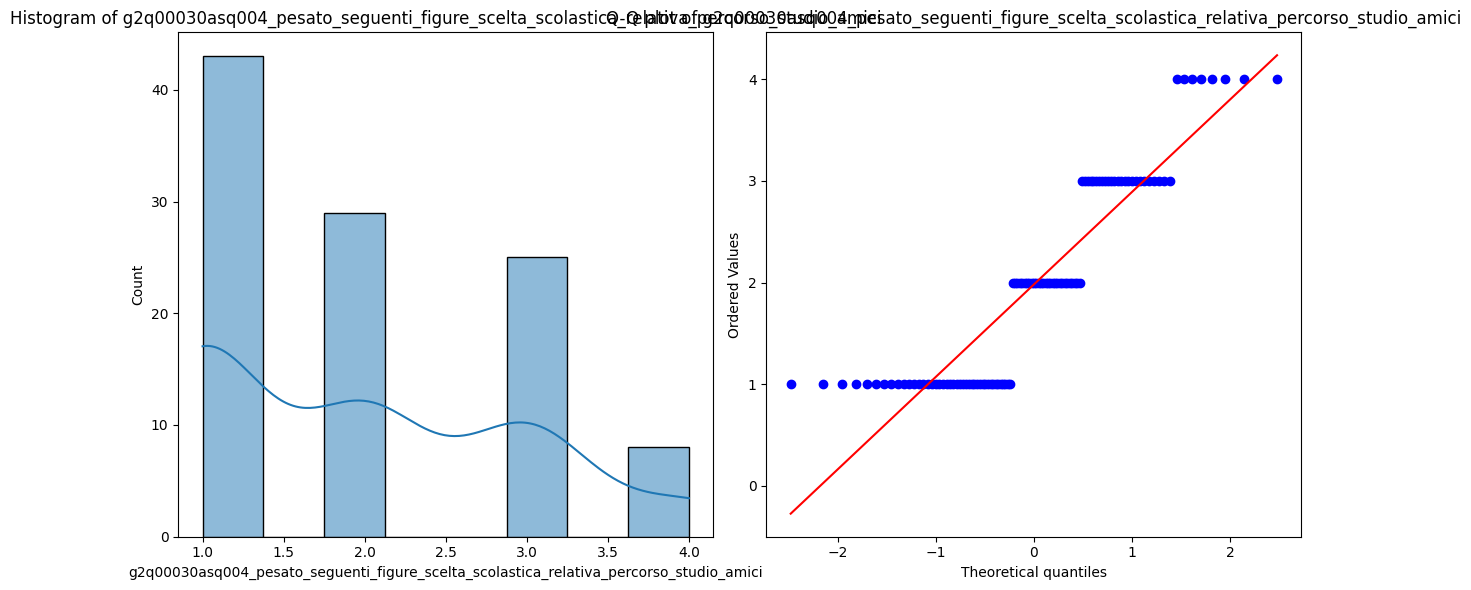

In [ ]:
from scipy import stats

for col in df_cleaned.columns:
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df_cleaned[col], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {col}')

    plt.tight_layout()
    plt.show()

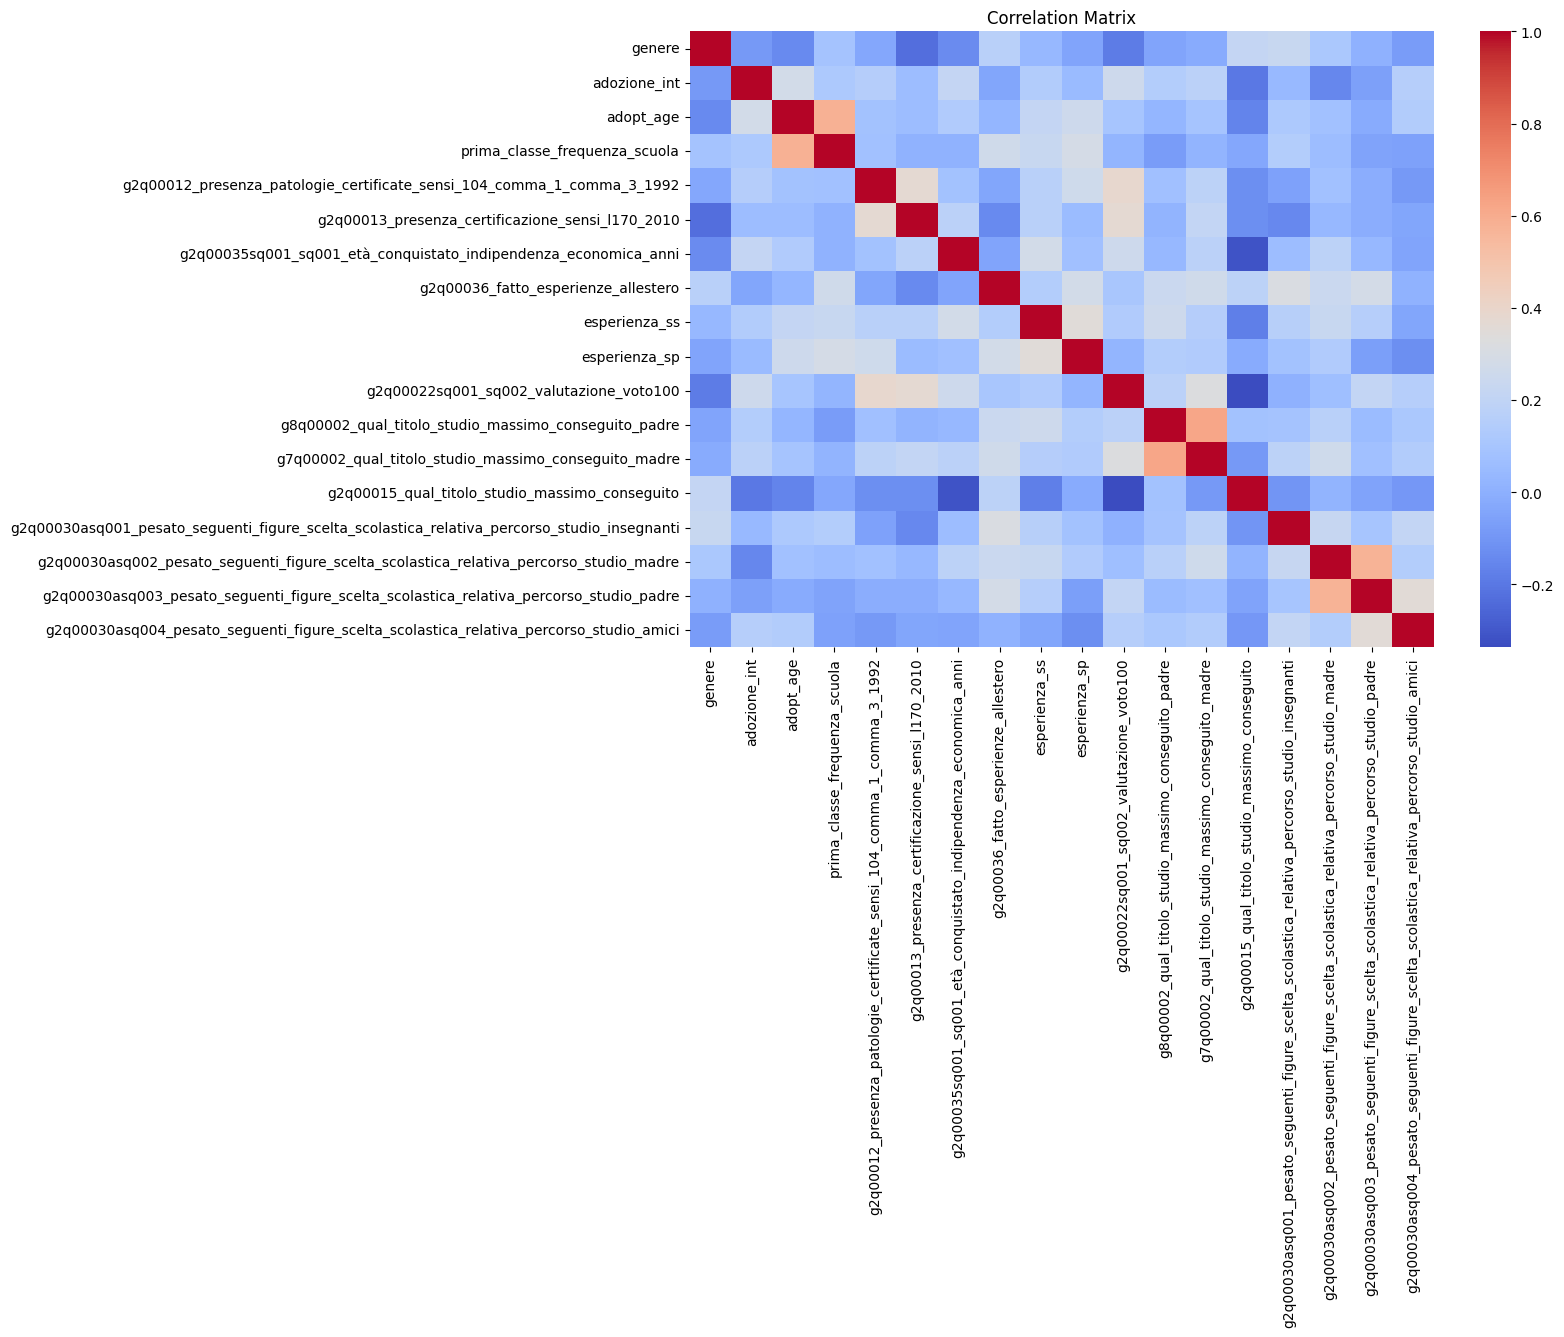

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

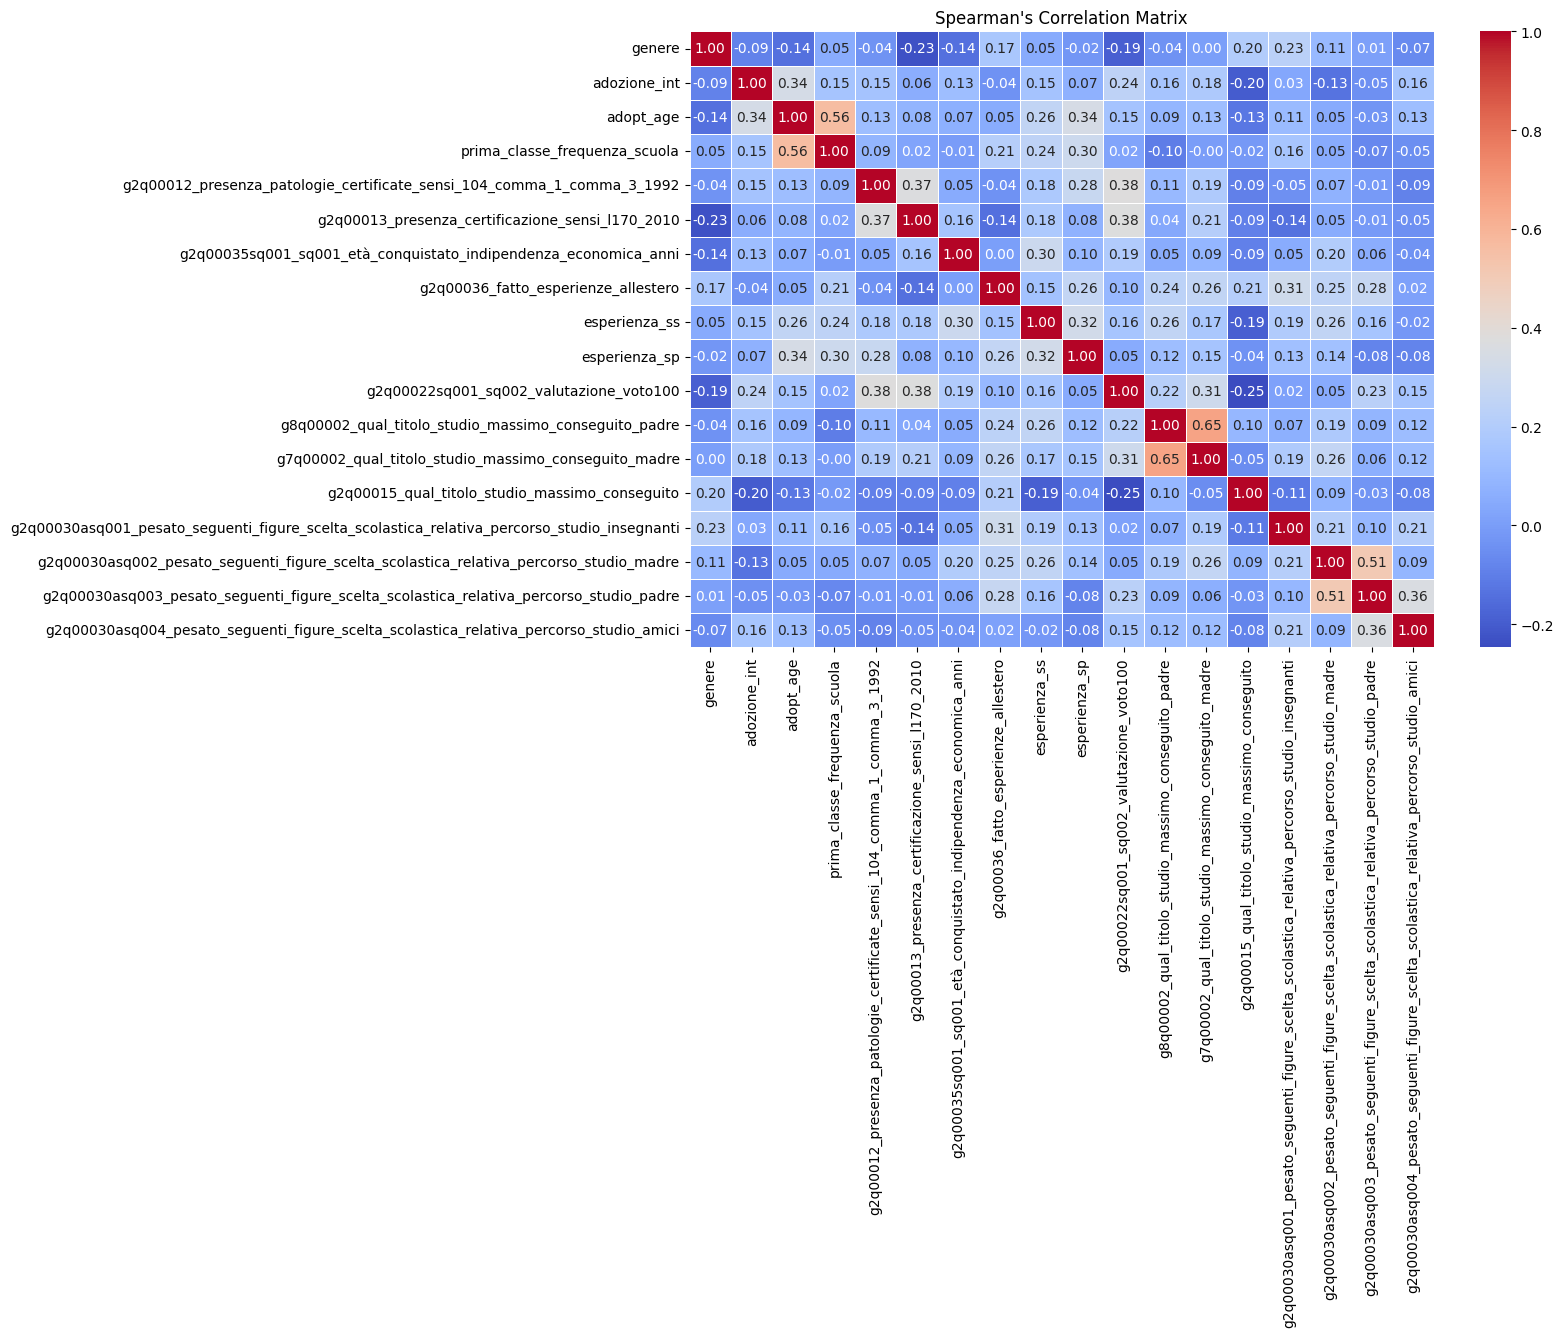

In [ ]:
spearman_corr = df_cleaned.corr(method="spearman")

# Plot Spearman's correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

categorical_vars = [col for col in categorical_vars if col in df_cleaned.columns]
for cat_var in categorical_vars:
    try:
        contingency_table = pd.crosstab(df_cleaned[cat_var], df_cleaned[target_variable])
        stat, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for Independence between {target_variable} and {cat_var}:")
        print(f"Statistic: {stat}, p-value: {p_value}, Degrees of Freedom: {dof}\n")
    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and genere:
Statistic: 6.636914457501241, p-value: 0.08441653507295305, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and adozione_int:
Statistic: 6.345512673398613, p-value: 0.09595831315090646, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and prima_classe_frequenza_scuola:
Statistic: 12.514055634590495, p-value: 0.8195949416691728, Degrees of Freedom: 18

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 7.569767441860465, p-value: 0.05579266739817207, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and g2q00013_presenza_certificazione_sensi_l170_2010:
Statistic: 7.569767441860465, p-

In [ ]:
import scipy.stats as stats

for cat_var in categorical_vars:
    try:
        groups = [df_cleaned[df_cleaned[cat_var] == val][target_variable].dropna()
                  for val in df_cleaned[cat_var].unique()]

        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

            print(f"Kruskal-Wallis test result for {target_variable} by {cat_var}:")
            print(f"Statistic: {kruskal_stat}, p-value: {kruskal_p_value}\n")
        else:
            print(f"Skipping {cat_var} - Not enough valid groups for Kruskal-Wallis test.")

    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by genere:
Statistic: 4.0774309045936015, p-value: 0.04345968967156473

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by adozione_int:
Statistic: 4.227159468438601, p-value: 0.03978196608243226

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by prima_classe_frequenza_scuola:
Statistic: 3.2862456091279335, p-value: 0.7721567658130325

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 0.9007217321571829, p-value: 0.34258826194034414

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00013_presenza_certificazione_sensi_l170_2010:
Statistic: 0.9007217321571829, p-value: 0.34258826194034414

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00036_fatto_esperienze_allestero:

In [ ]:
pip install imbalanced-learn


In [ ]:
smote = SMOTE(k_neighbors=1, random_state=42)
smote_tomek = SMOTETomek(smote=smote, random_state=42)

# Resample the data
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Check the new class distribution
class_counts_resampled = pd.Series(y_resampled).value_counts()
class_counts_resampled

,count
g2q00015_qual_titolo_studio_massimo_conseguito,
6,35
5,35
3,34
2,34


In [ ]:
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df["g2q00015_qual_titolo_studio_massimo_conseguito"] = y_resampled
resampled_df.head()

,genere,adozione_int,adopt_age,prima_classe_frequenza_scuola,g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992,g2q00013_presenza_certificazione_sensi_l170_2010,g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni,g2q00036_fatto_esperienze_allestero,esperienza_ss,esperienza_sp,g2q00022sq001_sq002_valutazione_voto100,g8q00002_qual_titolo_studio_massimo_conseguito_padre,g7q00002_qual_titolo_studio_massimo_conseguito_madre,g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti,g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre,g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre,g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici,g2q00015_qual_titolo_studio_massimo_conseguito
0,1,0,-1.091008,1,0,0,-0.750645,0.0,0,0,-0.596372,1.0,0.5,1,1,1,1,6
1,0,1,0.034848,1,0,0,1.196140,1.0,0,1,1.542884,7.0,7.0,3,1,1,1,3
2,0,1,-0.809544,1,0,1,1.196140,0.0,1,0,2.001296,3.0,6.0,1,4,4,1,3
3,0,1,2.005095,2,0,0,-0.777684,0.0,0,0,-0.596372,3.0,6.0,2,4,3,4,6
4,1,0,1.442167,6,0,0,-0.831762,1.0,0,1,-0.596372,3.0,6.0,4,4,3,3,6


In [ ]:
resampled_df.columns.tolist()

['genere',
 'adozione_int',
 'adopt_age',
 'prima_classe_frequenza_scuola',
 'g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992',
 'g2q00013_presenza_certificazione_sensi_l170_2010',
 'g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni',
 'g2q00036_fatto_esperienze_allestero',
 'esperienza_ss',
 'esperienza_sp',
 'g2q00022sq001_sq002_valutazione_voto100',
 'g8q00002_qual_titolo_studio_massimo_conseguito_padre',
 'g7q00002_qual_titolo_studio_massimo_conseguito_madre',
 'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
 'g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre',
 'g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre',
 'g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici',
 'g2q00015_qual_titolo_studio_massimo_conseguito']

## Regressions


In [ ]:
X_train, y_train = X_resampled, y_resampled

In [ ]:
if 'Intercept' in X_train.columns:
    X_train = X_train.drop(columns=['Intercept'])
model_ord = OrderedModel(y_train, X_train, distr='logit')
results = model_ord.fit(maxiter=15000, method='bfgs')
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.156316
         Iterations: 74
         Function evaluations: 76
         Gradient evaluations: 76
                                           OrderedModel Results                                           
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -159.57
Model:                                               OrderedModel   AIC:                             359.1
Method:                                        Maximum Likelihood   BIC:                             417.7
Date:                                            Tue, 11 Feb 2025                                         
Time:                                                    01:47:58                                         
No. Observations:                                             138                                         
Df Residuals:                                                 118              

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel


y_train_pred = results.predict(X_train).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Confusion Matrix:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [3 0 0 1 0 0]
 [3 0 4 1 0 0]
 [1 2 2 1 0 0]
 [0 1 0 2 0 0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00         0
     Class 2       0.00      0.00      0.00         4
     Class 3       0.20      0.12      0.15         8
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.05        21
   macro avg       0.03      0.02      0.03        21
weighted avg       0.08      0.05      0.06        21

Evaluation Results:
Training Accuracy: 0.0942
Test Accuracy: 0.0476
Training MAE: 2.4565
Test MAE: 2.4762


In [ ]:
selected_features = [
    "genere",
    "adozione_int",
    "adopt_age",
    "prima_classe_frequenza_scuola",
    "g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "g2q00013_presenza_certificazione_sensi_l170_2010",
    "g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni",
    "g2q00036_fatto_esperienze_allestero",
    "esperienza_sp",
    "g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre",
    "g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici"
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
if 'Intercept' in X.columns:
    X = X.drop(columns=['Intercept'])

model_ord = OrderedModel(y_train, X_train_selected, distr='logit')
results = model_ord.fit(maxiter=15000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.210870
         Iterations: 2231
         Function evaluations: 2980
                                           OrderedModel Results                                           
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -167.10
Model:                                               OrderedModel   AIC:                             362.2
Method:                                        Maximum Likelihood   BIC:                             403.2
Date:                                            Tue, 11 Feb 2025                                         
Time:                                                    01:48:00                                         
No. Observations:                                             138                                         
Df Residuals:                                                 124                                         
Df

In [ ]:
y_train_pred = results.predict(X_train_selected).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test_selected).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Confusion Matrix:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [2 1 0 1 0 0]
 [4 0 1 3 0 0]
 [2 1 2 1 0 0]
 [0 0 1 2 0 0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00         0
     Class 2       0.00      0.00      0.00         4
     Class 3       0.43      0.38      0.40         8
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.14        21
   macro avg       0.07      0.06      0.07        21
weighted avg       0.16      0.14      0.15        21

Evaluation Results:
Training Accuracy: 0.0942
Test Accuracy: 0.1429
Training MAE: 2.5145
Test MAE: 2.4286


In [ ]:
## multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Fit a multiclass logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', random_state=42, max_iter=10000)
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluate performance on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Get the unique class labels
unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

# Display results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Display evaluation metrics
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[2 1 1 0]
 [0 7 0 1]
 [0 3 3 0]
 [1 0 0 2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.67      0.50      0.57         4
     Class 3       0.64      0.88      0.74         8
     Class 5       0.75      0.50      0.60         6
     Class 6       0.67      0.67      0.67         3

    accuracy                           0.67        21
   macro avg       0.68      0.64      0.64        21
weighted avg       0.68      0.67      0.66        21

Evaluation Results:
Training Accuracy: 0.7609
Test Accuracy: 0.6667
Training MAE: 0.5290
Test MAE: 0.8095


In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(loss_function='MultiClass',
    iterations=680,
    depth=5,
    learning_rate=0.015,
    l2_leaf_reg=40,
    random_seed=42,
    early_stopping_rounds=18,
    random_strength=2,
    auto_class_weights="Balanced",
    bagging_temperature=1,
    verbose=False,
    eval_metric="TotalF1"   # focus on smaller classes
)

cat_model.fit(X_train, y_train)
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)


train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
train_mae_cat = mean_absolute_error(y_train, y_train_pred_cat)
test_mae_cat = mean_absolute_error(y_test, y_test_pred_cat)


conf_matrix_cat = confusion_matrix(y_test, y_test_pred_cat, labels=np.unique(y_test))
class_report_cat = classification_report(
    y_test, y_test_pred_cat, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0
)

print("\nCatBoost Results:")
print("Confusion Matrix:\n", conf_matrix_cat)
print("\nClassification Report:\n", class_report_cat)
print(f"Training Accuracy: {train_accuracy_cat:.4f}")
print(f"Test Accuracy: {test_accuracy_cat:.4f}")
print(f"Training MAE: {train_mae_cat:.4f}")
print(f"Test MAE: {test_mae_cat:.4f}")



CatBoost Results:
Confusion Matrix:
 [[3 0 1 0]
 [0 7 1 0]
 [1 0 4 1]
 [0 0 0 3]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.75      0.75      0.75         4
     Class 3       1.00      0.88      0.93         8
     Class 5       0.67      0.67      0.67         6
     Class 6       0.75      1.00      0.86         3

    accuracy                           0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.82      0.81      0.81        21

Training Accuracy: 0.8623
Test Accuracy: 0.8095
Training MAE: 0.2319
Test MAE: 0.4286


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Cross-validation accuracy: 0.7616 ± 0.0682


In [ ]:
catboost_features = cat_model.feature_names_
feature_importances = cat_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': catboost_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
6,g2q00035sq001_sq001_età_conquistato_indipenden...,19.802279
10,g2q00022sq001_sq002_valutazione_voto100,15.232657
7,g2q00036_fatto_esperienze_allestero,11.889662
15,g2q00030asq003_pesato_seguenti_figure_scelta_s...,7.754575
14,g2q00030asq002_pesato_seguenti_figure_scelta_s...,6.926751
2,adopt_age,6.895970
12,g7q00002_qual_titolo_studio_massimo_conseguito...,5.008942
9,esperienza_sp,4.762573
11,g8q00002_qual_titolo_studio_massimo_conseguito...,4.179977
13,g2q00030asq001_pesato_seguenti_figure_scelta_s...,3.633916


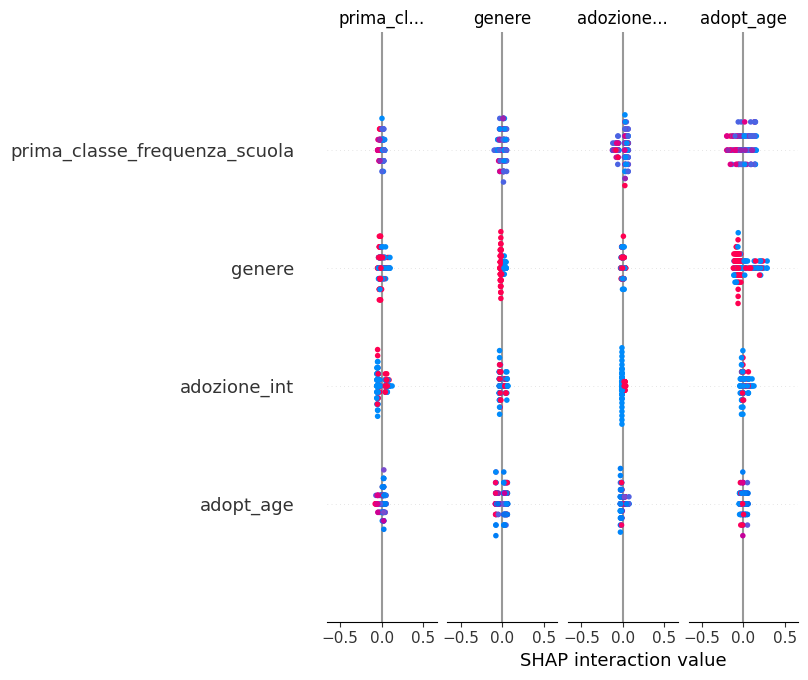

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define SVM pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features for better SVM performance
    ('svm', SVC(probability=True, random_state=42))  # Enable probability for ROC AUC calculation
])

# Define hyperparameter grid for SVM tuning
param_grid = [
    {'svm__C': [0.9, 0.95, 0.97], 'svm__kernel': ['linear']},  # Linear kernel tuning
    # {'svm__C': [1, 10, 100], 'svm__kernel': ['rbf'], 'svm__gamma': [0.01, 0.1, 1]}  # RBF kernel tuning
]

# Run GridSearchCV
grid_search = GridSearchCV(
    pipeline, param_grid, cv=10, scoring='roc_auc_ovr', refit=True, n_jobs=-1, verbose=1
)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Get the best SVM model
best_svm = grid_search.best_estimator_

# Predict probabilities for AUC calculation
y_train_proba = best_svm.predict_proba(X_train)
y_test_proba = best_svm.predict_proba(X_test)

# Compute ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
overfitting_gap = abs(train_auc - test_auc)

# Print results
print(f"\n Final Train ROC AUC: {train_auc:.4f}")
print(f"Final Test ROC AUC: {test_auc:.4f}")
print(f"Overfitting Gap (AUC): {overfitting_gap:.4f}")
print("Best Parameters (Final Tuning):", grid_search.best_params_)


Fitting 10 folds for each of 3 candidates, totalling 30 fits

 Final Train ROC AUC: 0.9379
Final Test ROC AUC: 0.8748
Overfitting Gap (AUC): 0.0631
Best Parameters (Final Tuning): {'svm__C': 0.97, 'svm__kernel': 'linear'}


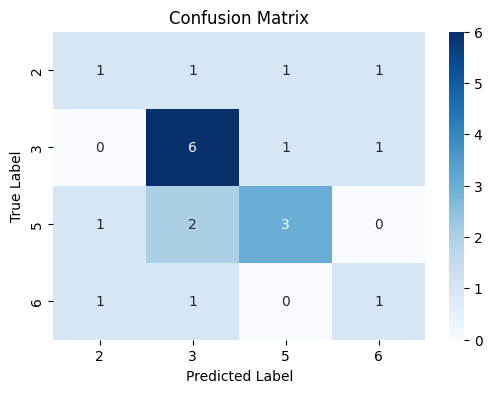

Classification Report:
               precision    recall  f1-score   support

           2       0.33      0.25      0.29         4
           3       0.60      0.75      0.67         8
           5       0.60      0.50      0.55         6
           6       0.33      0.33      0.33         3

    accuracy                           0.52        21
   macro avg       0.47      0.46      0.46        21
weighted avg       0.51      0.52      0.51        21



In [ ]:
y_test_pred = best_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print("Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=1))

<ipython-input-182-42bc5fc3d7dc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


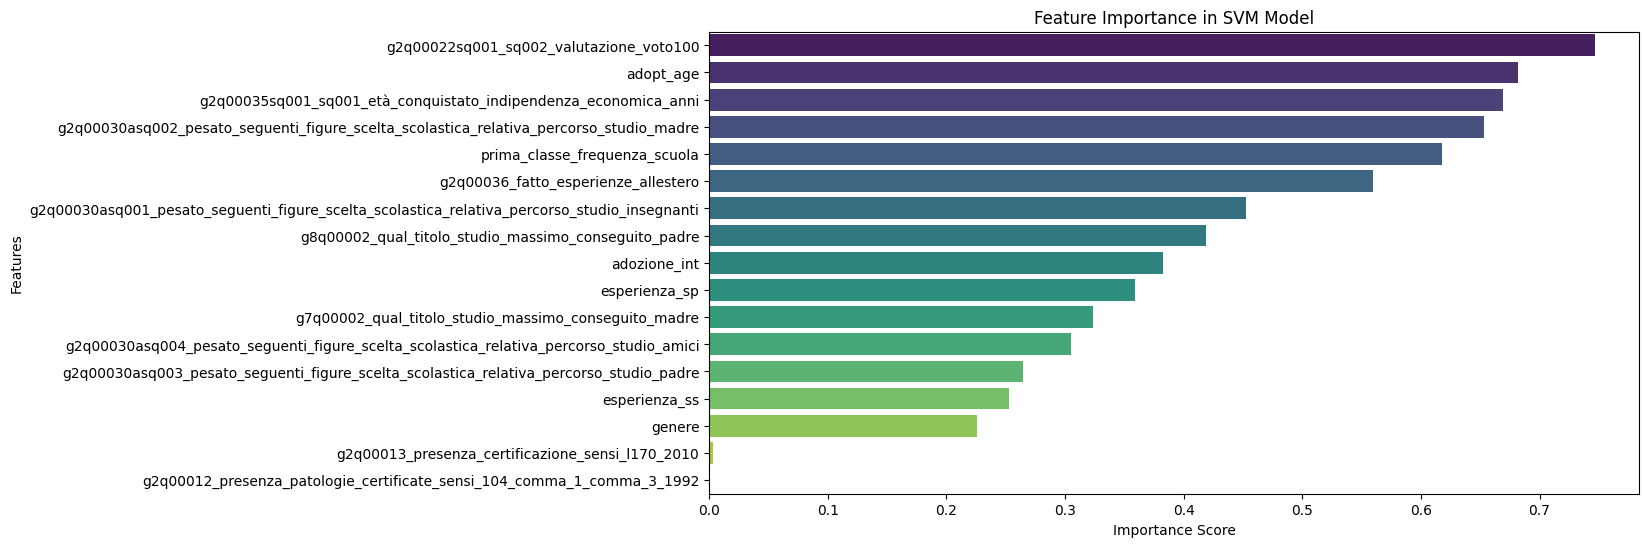

In [ ]:
feature_importance = np.abs(best_svm.named_steps['svm'].coef_).mean(axis=0)

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in SVM Model")
plt.show()

In [ ]:
pip install semopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.6 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=114f984236128b7b72b69e1e7457ba4ed98bb320bf27d140275ad083e4315064
  Stored in directory: /root/.cache/pip/wheels/d2/9a/31/fae291ff6a649bad125037eef8c7cc63d8c542e14bdcccea37
Successfully built semopy


In [ ]:
df_cleaned.columns

Index(['genere', 'adozione_int', 'adopt_age', 'prima_classe_frequenza_scuola',
       'g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992',
       'g2q00013_presenza_certificazione_sensi_l170_2010',
       'g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni',
       'g2q00036_fatto_esperienze_allestero', 'esperienza_ss', 'esperienza_sp',
       'g2q00022sq001_sq002_valutazione_voto100',
       'g8q00002_qual_titolo_studio_massimo_conseguito_padre',
       'g7q00002_qual_titolo_studio_massimo_conseguito_madre',
       'g2q00015_qual_titolo_studio_massimo_conseguito',
       'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
       'g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre',
       'g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre',
       'g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici'],


In [ ]:
from semopy import Model

sem_model_desc = """
# Define Latent Variables (if applicable)
family_support =~ g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre + g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici + g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre + g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti

health_factors =~ g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + g2q00013_presenza_certificazione_sensi_l170_2010

education_background =~ g8q00002_qual_titolo_studio_massimo_conseguito_padre + g7q00002_qual_titolo_studio_massimo_conseguito_madre

# Structural Model
g2q00015_qual_titolo_studio_massimo_conseguito ~ genere + adozione_int + adopt_age + prima_classe_frequenza_scuola + health_factors + family_support + education_background + esperienza_ss + esperienza_sp + g2q00036_fatto_esperienze_allestero + g2q00022sq001_sq002_valutazione_voto100
"""

sem_model = Model(sem_model_desc)
sem_model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
sem_model.inspect()


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,g2q00030asq002_pesato_seguenti_figure_scelta_s...,~,family_support,1.000000,-,-,-
1,g2q00030asq004_pesato_seguenti_figure_scelta_s...,~,family_support,0.537977,0.172437,3.119839,0.001809
2,g2q00030asq003_pesato_seguenti_figure_scelta_s...,~,family_support,0.920553,0.244763,3.761002,0.000169
3,g2q00030asq001_pesato_seguenti_figure_scelta_s...,~,family_support,0.415725,0.166388,2.498532,0.012471
4,g2q00012_presenza_patologie_certificate_sensi_...,~,health_factors,1.000000,-,-,-
5,g2q00013_presenza_certificazione_sensi_l170_2010,~,health_factors,0.941702,0.501908,1.876242,0.060622
6,g8q00002_qual_titolo_studio_massimo_conseguito...,~,education_background,1.000000,-,-,-
7,g7q00002_qual_titolo_studio_massimo_conseguito...,~,education_background,1.842129,0.806176,2.285022,0.022312
8,g2q00015_qual_titolo_studio_massimo_conseguito,~,genere,0.351763,0.270294,1.301411,0.193118
9,g2q00015_qual_titolo_studio_massimo_conseguito,~,adozione_int,-0.184021,0.256156,-0.718396,0.472513


In [ ]:
from semopy import calc_stats

calc_stats(sem_model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,122,144,174.944073,0.001198,456.670898,0.830672,0.616914,0.547833,0.616914,0.800137,0.064597,58.436562,140.709332,1.781719


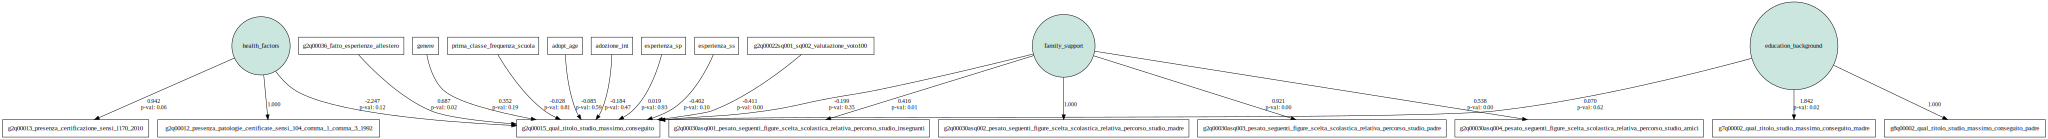

In [ ]:
from semopy import calc_stats, semplot

semplot(sem_model, filename='kids.pdf')

In [ ]:
sem2 = """
# Define Latent Variables
family_support =~ g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre + g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici + g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre + g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti
parental =~ g7q00002_qual_titolo_studio_massimo_conseguito_madre + g8q00002_qual_titolo_studio_massimo_conseguito_padre
psych =~ g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + g2q00013_presenza_certificazione_sensi_l170_2010

g2q00015_qual_titolo_studio_massimo_conseguito ~ psych + family_support + parental + g2q00036_fatto_esperienze_allestero + g2q00022sq001_sq002_valutazione_voto100
"""

sem_model = Model(sem2)
sem_model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
sem_model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,g2q00030asq002_pesato_seguenti_figure_scelta_s...,~,family_support,1.000000,-,-,-
1,g2q00030asq004_pesato_seguenti_figure_scelta_s...,~,family_support,0.538481,0.172585,3.120092,0.001808
2,g2q00030asq003_pesato_seguenti_figure_scelta_s...,~,family_support,0.920824,0.244954,3.759166,0.00017
3,g2q00030asq001_pesato_seguenti_figure_scelta_s...,~,family_support,0.416096,0.166511,2.498911,0.012458
4,g7q00002_qual_titolo_studio_massimo_conseguito...,~,parental,1.000000,-,-,-
5,g8q00002_qual_titolo_studio_massimo_conseguito...,~,parental,0.543731,0.236561,2.298477,0.021535
6,g2q00012_presenza_patologie_certificate_sensi_...,~,psych,1.000000,-,-,-
7,g2q00013_presenza_certificazione_sensi_l170_2010,~,psych,0.950921,0.519223,1.83143,0.067036
8,g2q00015_qual_titolo_studio_massimo_conseguito,~,psych,-2.436098,1.607171,-1.515768,0.129578
9,g2q00015_qual_titolo_studio_massimo_conseguito,~,family_support,-0.204104,0.221288,-0.922345,0.356349


In [ ]:
from semopy import calc_stats

calc_stats(sem_model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,41,57,96.148747,0.000003,246.34075,0.708733,0.609692,0.457377,0.609692,0.595068,0.113726,47.816322,114.165331,1.091839
